In [117]:
'''
Majority of code is adapted from the EarlyPrint Lab: https://earlyprint.org/jupyterbook/unsupervised.html
PCA visualization code adapted from Ask Python: https://www.askpython.com/python/examples/plot-k-means-clusters-python 
'''
# General Libraries Needed
import csv
import os 
import re
import numpy as np
import pandas as pd
from collections import defaultdict, Counter

# Functions for Unsupervised Clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Libraries for Graphing
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

def getTexts(folder):
    '''
    Takes in plain text files and outputs a tuple of lists, with the first being the text
    within each file as a string and the second list being the IDs of each text. 
    '''
    textStrings = []
    fileNames = []
    for file in os.listdir(folder):
        path = os.path.join(folder,file)
        f = open(path,'r')
        text = f.readlines()[0]
        textStrings.append(text)
        name = file.split('.')[0]
        fileNames.append(name)
        f.close()
    return textStrings,fileNames

def vectorize(strings,ids):
    # create vectorizer instance w/ normalization set to l2 by default 
    tfidf = TfidfVectorizer(min_df=2, sublinear_tf=True)
    # I am choosing to turn on sublinear term frequency scaling, which takes the log of
    # term frequencies and can help to de-emphasize function words like pronouns and articles. 
    # You might make a different choice depending on your corpus.

    # Once we've created the instance, we can "transform" our counts
    results = tfidf.fit_transform(strings)
    # Make results readable using Pandas
    return pd.DataFrame(results.toarray(), index=ids, columns=tfidf.get_feature_names_out()) # Convert information back to a DataFrame

def pca(kmeans,df):
    '''
    PCA visualization code comes from https://www.askpython.com/python/examples/plot-k-means-clusters-python 
    '''
    # Calculate PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df)
    label = kmeans.fit_predict(pca_results)
    u_labels = np.unique(label)
    #plotting the results:
    for i in u_labels:
        plt.scatter(pca_results[label == i , 0] , pca_results[label == i , 1] , label = i)
    plt.legend()
    plt.show()

def cluster(df,ids,num):
    # Create a KMeans instance that will look for a specified number of clusters
    # Random_state parameter helps for reproducibility. 42 is a common choice 
    kmeans = KMeans(n_clusters=num, random_state=42) 
    kmeans.fit(df) # Feed in our normalized data
    pca(kmeans,df)

    kmeans_groups = defaultdict(list)
    for k,v in zip(kmeans.labels_,ids):
        kmeans_groups[k].append(v)
        
    for v in kmeans_groups.values():
        print(v)

    return kmeans_groups

def keywords(csv,groups):
    df = pd.read_csv(csv)
    keywords = df['keywords']
    ids = df['id']
    numFiles = len(ids)
    count = 0
    dict = {}
    while count < numFiles:
        words = set(keywords[count].split('--'))
        # removing unnecessary keywords
        words.discard(' Early works to 1800.')
        words.discard('')
        # Removing unnecessary dates  
        newWords = []
        for w in words: 
            w = w.replace('.','')
            w = re.sub(r'\([^)]*\)','',w)
            w = re.sub(r' ca|-|[0-9]{4}|,','',w)
            w = w.strip()
            newWords.append(w)
        newWords = set(newWords)
        newWords.discard('')
        newWords.discard('-')
        newWords.discard('17th century')
        newWords.discard('To')
        dict[ids[count]] = newWords
        count += 1
    for k,v in groups.items():
        print(f'Group {k}')
        keyterms = []
        for name in v: 
            keyterms.extend(dict[name])
        print(Counter(keyterms))

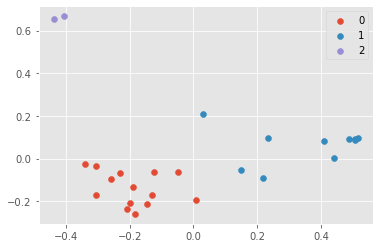

['A01932', 'A04813', 'A07886', 'A12458', 'A12460', 'A12466', 'A13290', 'A21108', 'A51598', 'A57391', 'A69149', 'A77422', 'B00052', 'B00963']
['A02495', 'A03149', 'A10821', 'A31106', 'A41427', 'A66847', 'A68617', 'A71305', 'A71306', 'A71307']
['A37936', 'A83297']
Group 0
Counter({'Great Britain': 5, 'History': 5, 'Description and travel': 4, 'Commerce': 3, 'Colonial period': 3, 'New England': 2, 'Massachusetts': 2, 'Colonies': 2, 'Sermons English': 2, 'Cape Breton Island': 1, 'Discovery and exploration': 1, 'Guyana': 1, 'East India Company': 1, 'East Indies': 1, 'Indians of North America': 1, 'Virginia': 1, 'OT': 1, 'Sermons': 1, 'Bible': 1, 'Genesis XII 13': 1, 'Colonization': 1, 'Newfoundland': 1, 'Mercantile system': 1, 'Balance of trade': 1, 'Commercial policy': 1, 'Prophecies': 1, 'Apocalyptic literature': 1, 'Politics and government': 1, 'Europe': 1, 'Fifth Monarchy Men': 1, 'Africa East': 1, 'Asia': 1, 'Charles I': 1, 'America': 1, 'Canada': 1})
Group 1
Counter({'Voyages and trav

In [118]:
folder = '/srv/data/texts'
csv = '/srv/data/CSVs/EPtuning.csv'
info = getTexts(folder)
df = vectorize(info[0],info[1])
groups = cluster(df,info[1],3)
keywords(csv,groups)